# Prediction of Spam 
### Jake Andersen-Lum, Stephen Hong, Yicheng Huang, Ella Ren
### STAT301: Statistical Modelling for Data Science
### March 31, 2025

In [1]:
install.packages("glmnet") # need this to run once before commenting out
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(modelr)
library(pROC)
library(rsample)
library(caret)
library(glmnet)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attachi

## Introduction

As technology develops, an increasing number of users choose to use email as a method of communication. At the same time, the number of unsolicited spam emails has grown. This not only makes mailboxes cluttered and causes users to miss important emails, but it is also a burden on the ISP's system (Cranor & LaMacchia, 1998). Therefore, predicting spam is an important way to guarantee user access and maintain the integrity of the email system.

Our research question is: Can we accurately predict whether an email is spam using the variables in our [email](https://www.openintro.org/data/index.php?data=email) dataset? The primary goal of this paper is prediction, and we hope to build a model that can accurately identify spam by using these features.

## Methods and Results

#### a) Data

The dataset is called [email](https://www.openintro.org/data/index.php?data=email), which is sourced from OpenIntro, and the source is the first three months of 2012 for David Diez's Gmail Account.
The dataset contains 3921 observations and 21 variables focusing on the information of incoming emails. This is an observational data.

**Citation**: [email](https://www.openintro.org/data/index.php?data=email)

In [2]:
# Loaded the data from an open source
email <- read_csv(url("https://www.openintro.org/data/csv/email.csv"))

Rows: 3921 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): winner, number
dbl  (18): spam, to_multiple, from, cc, sent_email, image, attach, dollar, i...
dttm  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Variables information

| Variable Name    | Type | Description |
|---------|-----|-------|
| spam   | Categorical  |  Indicator for whether the email was spam (1 = Yes, 0 = No).   |
| to_multiple     | Categorical  |  Indicator for whether the email was addressed to more than one recipient (1 = Yes, 0 = No).   |
| from | Categorical  |  Indicator for whether the message was listed as from anyone (1 = Yes, 0 = No).   |
| cc   | Numerical  |  The number of people cc'ed (carbon copy) in the email.  |
| sent_email     | Categorical  |  Indicator for whether the sender had been sent an email in the last 30 days (1 = Yes, 0 = No).   |
| time | Numerical  |  Time at which email was sent.   |
| image   | Numerical  |  The number of images attached in the email.   |
|   attach   | Numerical  |  The number of attached files in the email.   |
| dollar | Numerical  |  The number of times a dollar sign or the word "dollar" appeared in the email.   |
|  winner  | Categorical  |  Indicates whether "winner" appeared in the email (Yes, No).   |
|   inherit   | Numerical  |  The number of times "inherit" (or an extension, such as "inheritance") appeared in the email.   |
| viagra | Numerical  |  The number of times "viagra" appeared in the email.   |
|  password  | Numerical  |  The number of times "password" appeared in the email.   |
|   num_char   | Numerical  |  The number of characters in the email, and the unit is thousands.   |
| line_breaks | Numerical  |  The number of line breaks in the email (does not count text wrapping).   |
|  format  | Categorical  |  Indicator for whether the email was written using HTML (1 = Yes, 0 = No).   |
|   re_subj   | Categorical  |  Indicator for whether the subject started with "Re:", "RE:", "re:", or "rE:" (1 = Yes, 0 = No).  |
| exclaim_subj | Categorical  |  Indicator for whether there was an exclamation point in the subject (1 = Yes, 0 = No).   |
|  urgent_subj  | Categorical  |  Indicator for whether the word “urgent” was in the email subject (1 = Yes, 0 = No).   |
|   exclaim_mess   | Numerical  |  The number of exclamation points in the email message.   |
| number | Categorical  |  Indicates whether there was no number, a small number (under 1 million), or a big number (none, small, big).   |

#### Initially Dropped Variables
- `time`: Time is removed from the dataset because emails may be sent from different time zones and cause noise.

#### b) Exploratory Data Analysis (EDA)

In [3]:
# Selected variables and converted categorical variables to factors
email <- email |>
    select(-time) |>
    mutate(across(c(spam, to_multiple, from, sent_email, 
                    winner, format, re_subj, exclaim_subj, urgent_subj, number), as.factor))

In [4]:
# Main developer: Jake Andersen-Lum
# Pivot to long format to get one column for variable names, and one for values
email_long <- email |>
  pivot_longer(cols = where(is.factor), names_to = "variable", values_to = "value")

# Count and calculate proportions
email_props <- email_long |>
  group_by(variable, value) |>
  summarise(n = n(), .groups = "drop") |>
  group_by(variable) |>
  mutate(prop = n / sum(n))

# Plot
bar_email <- ggplot(email_props, aes(x = variable, y = prop, fill = value)) +
                  geom_bar(stat = "identity") +
                  scale_y_continuous(labels = scales::percent) +
                  labs(title = "Proportions of Categorical Variables",
                       x = "Variable", y = "Proportion",
                       fill = "Category") +
                  theme_minimal() +
                  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [5]:
# Main developer: Ella Ren
# Contributors: Yicheng Huang (commented)

# Compute correlation matrix for numeric variables
email_matrix <- 
   cor(email[, sapply(email, is.numeric)], ) %>%
   as_tibble(rownames = 'v1') %>%
   pivot_longer(-v1, names_to = "v2", values_to = "corr")

# Create a heatmap of the correlations
heatmap_email <- 
  email_matrix %>%
  ggplot(aes(x = v1, y = v2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation \n",
      palette =  "RdBu",
      direction = 1, 
      limits = c(-1, 1)
    ) +
    labs(x = "", y = "", title = "Heatmap for Numerical and Binary Variables") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 13, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 13, hjust = 1),
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 11),
        legend.key.size = unit(1.3, "cm")
    ) +
    coord_fixed() +
   geom_text(aes(x = v1, y = v2, label = round(corr, 2)), color = "black", size = 3)

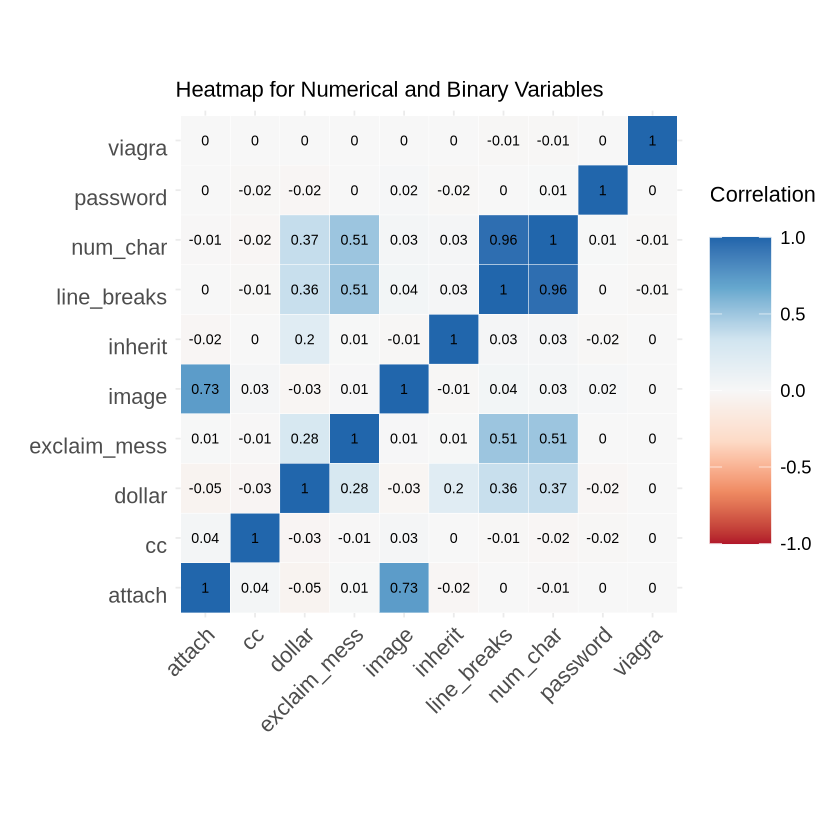

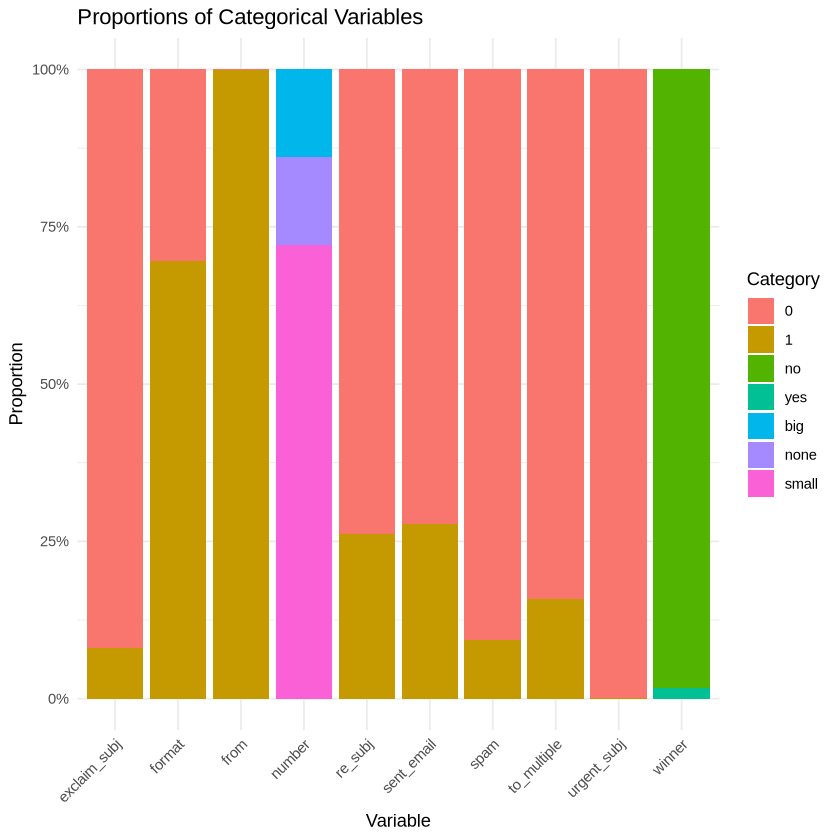

In [6]:
heatmap_email
bar_email

A potential problem coming from the heatmap is that there are certain variables with high correlation such as `num_char` + `line_breaks` and `image` + `attach`. These high correlation values could indicate a violation of multicollinearity when using such variables in a regression model.

Looking at the bar graph, `from`, `urgent_subj`, and `viagra` all seem only to have one response. To further investigate, we found the number of rows corresponding to when `from` is not equal to one, `viagra` is not equal to zero, and `urgent_subj` does not equal one.

In [7]:
# main developer: Ella Ren

# find number of rows where from does not equal 1
from_0 = nrow(filter(email, from != 1))

# find number of rows where viagra does not equal 0
viagra_1 = nrow(filter(email, viagra != 0))

# find number of rows where urgent_subj does not equal 0
urgent_1 = nrow(filter(email, urgent_subj != 0))

cat("number of rows where from does not equal 1:", from_0, "\n") 

cat("number of rows where viagra does not equal 0:", viagra_1, "\n")

cat("number of rows where where urgent_subj does not equal 0:", urgent_1, "\n")

number of rows where from does not equal 1: 3 
number of rows where viagra does not equal 0: 1 
number of rows where where urgent_subj does not equal 0: 7 


After investigating, we found that `from` only had 3 rows with values different from 1, and `viagra` had 1 row different from 0, while `urgent_subj` had a bit more variability. Ultimately, we decided to eliminate `from` and `viagra` during the fitting of our model, leaving `urgent_subj` in.

No missing values were present in our dataset.

#### c) Methods: Plan

#### Data Splitting and Model Choice

Since we are creating a predictive model, we need to split the dataset into testing and training data to evaluate the model's performance. We will be creating a logistic regression model with the training data because our response variable (spam) is binary.

In [8]:
set.seed(3)
# All group members developed this code together with the guidance of tutorial 10

# Split the data into training and testing sets (70% training, 30% testing)
email_split <- initial_split(email, prop = 0.7, strata = spam)
email_training <- training(email_split)
email_testing <- testing(email_split)

#### Variable Selection

There are many approaches we could take to estimate the model. Our group chose to implement LASSO as it is the method we were most familiar with. Using LASSO, we were able to select a subset of covariates for our model through the use of our training data. 

In [9]:
# All group members developed this code together with the guidance of tutorial 10
# Create model and response matrix for both training and testing sets 
matrix_X_train <- model.matrix(object = spam ~ ., data = email_training)[,-1]
matrix_Y_train <- as.matrix(email_training$spam, ncol = 1)

matrix_X_test <- model.matrix(object = spam ~ ., data = email_testing)[, -1]

In the above block, we turned the training and testing datasets into a design matrix for all covariates, excluding the first column of intercepts. The response (spam) is also turned into a matrix for the training set, this allows consistency of types when using LASSO.

In [10]:
set.seed(4)

# All group members developed this code together with the guidance of tutorial 10
# Finds lambda that produces the highest average AUC when LASSO penalty is used
email_cv_lambda_LASSO <- cv.glmnet(
    x = matrix_X_train, y = matrix_Y_train,
    alpha = 1,
    family = "binomial",
    type.measure = "auc",
    nfolds = 5
    )

In [12]:
print("Figure 1: LASSO Feature Selection")
coef(email_cv_lambda_LASSO, s = "lambda.min")

[1] "Figure 1: LASSO Feature Selection"


21 x 1 sparse Matrix of class "dgCMatrix"
                        s1
(Intercept)    3.279186185
to_multiple1  -2.150292990
from1         -3.586503893
cc             0.026301986
sent_email1   -4.484298952
image         -1.138735280
attach         0.457604884
dollar        -0.065590401
winneryes      1.901224859
inherit        0.292728186
viagra         0.626213047
password      -0.595083367
num_char       .          
line_breaks   -0.002619249
format1       -0.636083110
re_subj1      -1.771953236
exclaim_subj1  .          
urgent_subj1   3.541852768
exclaim_mess   0.008066717
numbernone     0.165044993
numbersmall   -0.892607210

We used 5-fold cross-validation on our training data to fit our logistic models using LASSO. We maximized AUC, which evaluates how well the model can distinguish between the binary responses. Through LASSO, we selected all variables except `num_char` and `exclaim_subj` and end up fitting a logistic regression model using the training data without these variables.

In [13]:
chosen_model = glm(spam ~.-num_char -exclaim_subj -from -viagra, family = "binomial", data = email_training)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Now, we'll get a sense of how good our model is by having it predict on the training data.

In [14]:
# Main developer: Stephen Hong
# code adapted from worksheet 10
# Predict on training set
train_probs <- predict(chosen_model, type = "response")

email_pred_class <- 
  round(train_probs, 0)

email_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_training$spam),
    positive = "1"
)

# store confusion matrix metrics in a table
precision <- email_confusion_matrix$byClass["Precision"]
recall    <- email_confusion_matrix$byClass["Recall"]
f1_score  <- 2 * precision * recall / (precision + recall)

conf_mat_stats <- tibble(Sensitivity = c(email_confusion_matrix$byClass["Sensitivity"]),
                         Specificity = c(email_confusion_matrix$byClass["Specificity"]),
                         Precision = precision,
                         Accuracy = c(email_confusion_matrix$overall["Accuracy"]),
                         Kappa = c(email_confusion_matrix$overall["Kappa"]),
                         F1 = f1_score)

print("Figure 2: Metrics of 0.5 threshold")
email_confusion_matrix$table
conf_mat_stats   

[1] "Figure 2: Metrics of 0.5 threshold"


          Reference
Prediction    0    1
         0 2462  226
         1   17   39

Sensitivity,Specificity,Precision,Accuracy,Kappa,F1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1471698,0.9931424,0.6964286,0.9114431,0.2165932,0.2429907


We used a confusion matrix to interpret the metrics of our model. The trained model has a high accuracy when predicting on the test data, which is expected, but is not a good metric for this model's evaluation because spam emails are significantly underrepresented in this dataset. We can see this through the very high specificity metric, as most of the emails in our dataset are not spam. A metric like sensitivity is more valuable for evaluating the model's performance, as this metric tells us how many spam emails the model classified correctly. The sensitivity of our model is poor, meaning our model currently predicts almost everything to be non-spam.

To counteract this, we will change the threshold value. To determine what to change the threshold to, we'll look at the ROC curve (based on the training data) and pick the best point along the curve.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



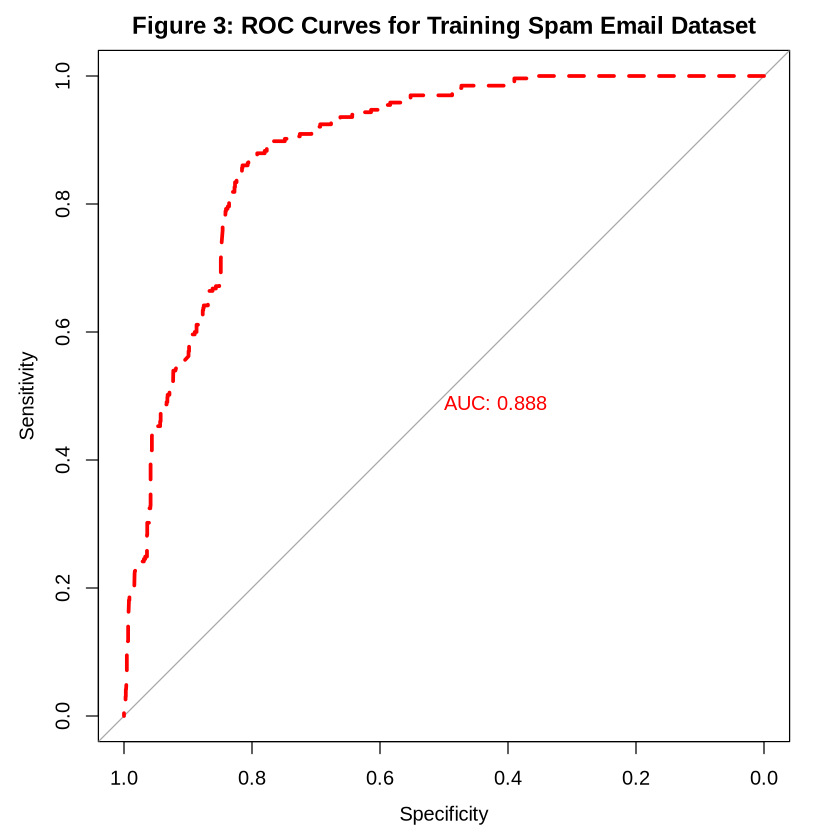

In [15]:
# main developer: Jake Andersen-Lum

# ROC on training set
roc_train <- roc(response = email_training$spam, predictor = train_probs)

# Find threshold (on training set only)
coords_train <- coords(roc_train, x = "best", best.method = "closest.topleft", transpose = FALSE)
best_thresh <- coords_train$threshold

plot(roc_train, print.auc = TRUE, col = "red", lwd = 3, lty = 2, main = "Figure 3: ROC Curves for Training Spam Email Dataset")

From this curve, we select the top-left point, representing the overall best decision threshold to maximize sensitivity and specificity. We call it `best_thresh`.

In [16]:
options(repr.plot.width = 8, repr.plot.height = 8)
# Main developer: Stephen Hong + Jake Andersen-Lum

# Define both thresholds
thresholds <- c(0.5, best_thresh)
threshold_labels <- c("Default 0.5", "Custom Threshold Using ROC Curve")

# Initialize empty list to collect results
conf_mat_stats_list <- list()

# Loop through both thresholds
for (i in 1:2) {
  threshold <- thresholds[i]
  label <- threshold_labels[i]
  
  # Apply threshold
  email_pred_class <- ifelse(train_probs > threshold, 1, 0)

  # Compute confusion matrix
  cm <- confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_training$spam),
    positive = "1"
  )
  
  # Store results in a tibble
precision <- cm$byClass["Precision"]
recall    <- cm$byClass["Recall"]
f1_score  <- 2 * precision * recall / (precision + recall)

  conf_mat_stats_list[[i]] <- tibble(
    Threshold = label,
    Sensitivity = cm$byClass["Sensitivity"],
    Specificity = cm$byClass["Specificity"],
    Precision   = precision,
    Accuracy    = cm$overall["Accuracy"],
    Kappa       = cm$overall["Kappa"],
    F1          = f1_score
  )
}

# Combine both rows into one table
conf_mat_stats_compare <- bind_rows(conf_mat_stats_list)

# create new confusion matrix
email_confusion_matrix_new_threshold <- 
    confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_training$spam),
    positive = "1"
)

# Show result
#
print("Figure 4: Metrics of ROC-selected threshold")
email_confusion_matrix_new_threshold$table
conf_mat_stats_compare

[1] "Figure 4: Metrics of ROC-selected threshold"


          Reference
Prediction    0    1
         0 2020   37
         1  459  228

Threshold,Sensitivity,Specificity,Precision,Accuracy,Kappa,F1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Default 0.5,0.1471698,0.9931424,0.6964286,0.9114431,0.2165932,0.2429907
Custom Threshold Using ROC Curve,0.8603774,0.8148447,0.3318777,0.8192420,0.3946102,0.4789916


We now have new metrics according to the new threshold, and can build a table comparing it to the original threshold of 0.5. We can clearly see that with this new threshold, our sensitivity has increased, at the slight cost of specificity, precision, and accuracy. Overall, though, the price paid is negligible compared to the gains we make in kappa and f1 score. Our confusion matrix bears this out, showing that while we do now make many more false positive predictions, we now correctly identify spam vastly more often. Finally, we can check our results on the test data.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



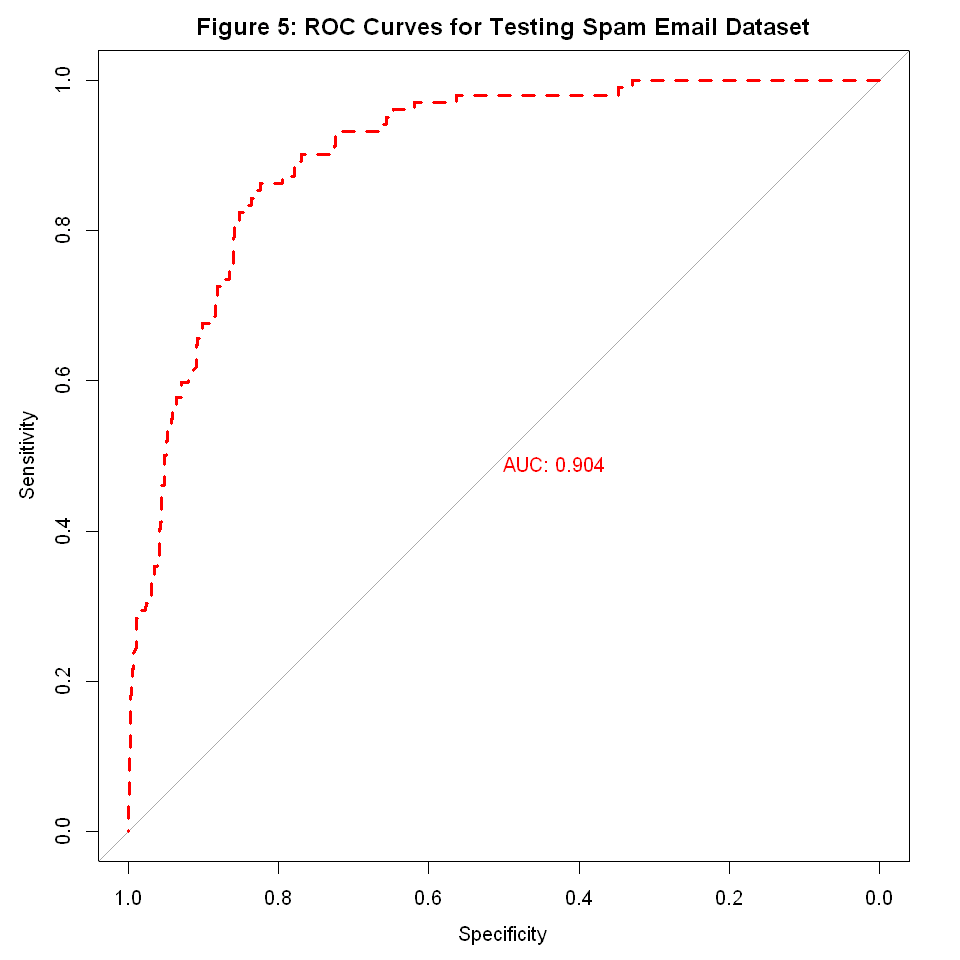

In [62]:
# main developer: Jake Andersen-Lum

# ROC for the chosen model 
roc_glm_new <- roc(
  response = email_testing$spam,
  predictor = predict(chosen_model,
                      newdata = email_testing,
                      type = "response"))

plot(roc_glm_new, print.auc = TRUE, col = "red", lwd = 3, lty = 2, main = "Figure 5: ROC Curves for Testing Spam Email Dataset")

An AUC of 0.904 tells us that our model is fairly accurate over many thresholds. Now let's check our model's metrics using the custom threshold we found.

In [63]:
# Predict on training set
test_probs <- predict(chosen_model, email_testing, type = "response")

email_pred_class <- 
  email_pred_class <- ifelse(test_probs > best_thresh, 1, 0)

email_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_testing$spam),
    positive = "1"
)

# store confusion matrix metrics in a table
precision <- email_confusion_matrix$byClass["Precision"]
recall    <- email_confusion_matrix$byClass["Recall"]
f1_score  <- 2 * precision * recall / (precision + recall)

conf_mat_stats <- tibble(Sensitivity = c(email_confusion_matrix$byClass["Sensitivity"]),
                         Specificity = c(email_confusion_matrix$byClass["Specificity"]),
                         Precision = precision,
                         Accuracy = c(email_confusion_matrix$overall["Accuracy"]),
                         Kappa = c(email_confusion_matrix$overall["Kappa"]),
                         F1 = f1_score)

print("Figure 6: Test Metrics")
email_confusion_matrix$table
conf_mat_stats

[1] "Figure 6: Test Metrics"


          Reference
Prediction   0   1
         0 889  15
         1 186  87

Sensitivity,Specificity,Precision,Accuracy,Kappa,F1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8529412,0.8269767,0.3186813,0.8292268,0.3866025,0.464


## Discussion
In conclusion, our original data was quite poor at predicting spam correctly due to the imbalance in spam/non-spam classification in the original dataset. However, by adjusting the threshold a little using the ROC curve, we were able to make our model better at predicting true spam. 

One way our model could be improved is by looking more into the possibility of interaction between terms, as the addition of interaction could drastically change how well our model predicts spam. We could also try different ways of balancing spam and non-spam during splitting and fitting, using different methods of feature selection or regularization like Ridge, or using different methods to determine the decision threshold, such as looking at the Precision-Recall Curve. Additionally, researching more into the method used by large companies to classify spam email, like Google or Microsoft would be an interesting topic. 

## References
Cranor, L. F., & LaMacchia, B. A. (1998). Spam! *Communications of the ACM, 41*(8), 74–83. https://doi.org/10.1145/280324.280336 